In [ ]:
# based on code from https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-onencoded_space_dim-mnist-dataset-d65145c132ac 

In [ ]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random, os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class MapsDataset(torch.utils.data.Dataset):
    def __init__(self, map_dir, transform=None, shape = (100,100)):
        self.maps = []                                                  # create a list to hold all paths read from file
        for filename in os.listdir(map_dir):
            with open(os.path.join(map_dir, filename), 'r') as f:                                   # open in readonly mode
                self.flat_map = np.loadtxt(f)                                                   # load in the flat path from file
                self.map = np.asarray(self.flat_map, dtype=int).reshape(shape[0], shape[1])     # unflatten the map from the file
                self.maps.append(self.map)                              # add the path to paths list
        self.transform = transform
        print("Done!")

    def __len__(self):
        return len(self.maps)

    def __getitem__(self, idx):
        x = np.float32(self.maps[idx])

        # if self.transform:
        #     x = self.transform(x).cuda()

        return x

In [ ]:
data_dir = 'dataset'

data_transform = transforms.Compose([
transforms.ToTensor(),
])

dataset = MapsDataset(map_dir = f"./env/maps_size_64x64/", shape = (64,64), transform=data_transform)

m=len(dataset)
train_dataset, test_dataset = random_split(dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 5, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 5, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),     
            nn.Conv2d(256, 512, 7, stride=2, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(512, 1, 1))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 7, 
            stride=2, padding=0, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 5, 
            stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 5, 
            stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 5, 
            stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.0001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

In [ ]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader
    for batch_index, image_batch in enumerate(dataloader):
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        image_batch = image_batch[:,None,:,:]
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for batch_index, image_batch in enumerate(dataloader):
            # Move tensor to the proper device
            image_batch = image_batch[:,None,:,:]
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = torch.tensor(test_dataset[i]).unsqueeze(0).unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [ ]:

num_epochs = 50
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   if epoch % 25 == 0:
      plot_ae_outputs(encoder,decoder,n=10)
plot_ae_outputs(encoder,decoder,n=10)

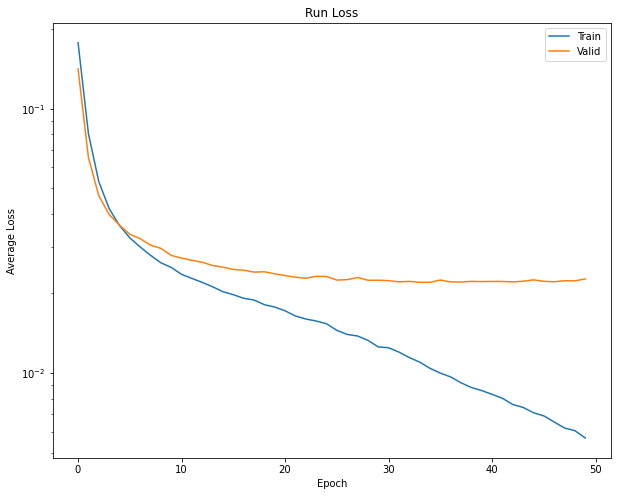

In [17]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
# plt.grid()
plt.legend()
plt.title('Run Loss')
plt.show()

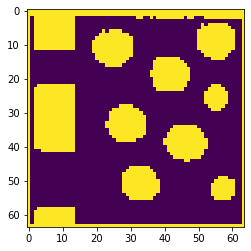

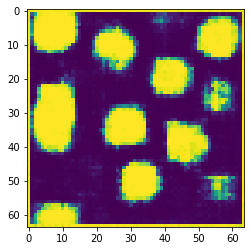

In [42]:
flat_map = np.loadtxt("env/test_map.txt", skiprows=2)                                                   # load in the flat path from file
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(64, 64)).to(device, dtype=torch.float)     # unflatten the map from the file

plt.imshow(map.cpu())
plt.show()

map_4d = map.unsqueeze(0).unsqueeze(0)

encoded_map = encoder(map_4d)
decoded_map = decoder(encoded_map)

new_map_2d = decoded_map.squeeze()

plt.imshow(new_map_2d.cpu().detach().numpy())
plt.show()